# Experiments with textual misinformation detection using machine learning models
In this experiment, we train and test machine learning models for detecting misinformation based purely on the text. We evaluated the performance of 5 classification models with wide use in text classification problems.

**Models:**
* Logistic regression
* Bernoulli Naive-Bayes
* Multinomial Naive-Bayes
* Linear SVM
* KNN
* Random forest
* Gradient Boosting
* Multilayer Perceptron

# NOTES TO MYSELF

**To do:**
* handcrafted linguistic features
* ~~hyperparamater tunning; validation~~


**References:**
* https://towardsdatascience.com/text-classification-in-python-dd95d264c802
* https://github.com/miguelfzafra/Latest-News-Classifier/tree/master/0.%20Latest%20News%20Classifier/04.%20Model%20Training


In [132]:
#utils
import emoji, re, string, time, os
from utils import getTestMetrics
import pandas as pd
import numpy as np
from scipy.stats import randint
import pickle

#nlp
import nltk
from nltk.corpus import stopwords
import spacy

#dataviz
import matplotlib.pyplot as plt
import seaborn as sns

#features
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

#models
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble  import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

#data balancing
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

%matplotlib inline
sns.set(style="darkgrid")

start_time = time.time()

## Experiments

## Subsets:
* Viral
* All

### Feature engineering
* bow: binary bag of words
* tfidf: term frequency–inverse document frequency
* max_features: limits to 500

### Pre-processing
* processed: convert url in just the domain, separate emojis, remove punctuation, downcase, lemmatization, remove stop words

### Data balancing
* smote: Synthetic Minority Oversampling Technique
* undersampling: random undersampling
* random_oversampling


### Conclusions:
* Smote is not the best oversampling technique for text, specially for BOW features
* Pre-processing the data didn't appear to have a great impact, despite the great reduction of dimentionality
* BOW features are comparably to TF-IDF features
* Random oversampling is a good oversampling technique
* Use a maximum number of features wasn't a good approach

In [133]:
base = '2018'
subset = 'viral'
path_dir = 'results/' + str(base) + '/' + subset + '/ml/'
path_dir

'results/2018/viral/ml/'

In [134]:
# best results analysis
df_best = pd.DataFrame(columns=['model', 'accuracy', 'precision', 'recall', 'f1 score', 'auc score','vocab'])
#iterates over files
exp = []
for filename in os.listdir(path_dir):
    exp.append(str(filename).replace('.csv',''))
    file_path = path_dir + filename
    #print(filename)
    df_temp = pd.read_csv(file_path)
    best_ix = df_temp['f1 score'].argmax() #f1 score
    best = df_temp.iloc[best_ix]
    df_best = df_best.append(best)
df_best['experiment'] = exp
cols = df_best.columns.tolist()
cols = cols[-2:] + cols[:-2]
df_best = df_best[cols]
df_best = df_best.reset_index()
df_best = df_best.drop(columns = ['index'])
df_best = df_best.sort_values(by='f1 score',ascending=False)
df_best.style.background_gradient(cmap='Blues')

,vocab,experiment,model,accuracy,precision,recall,f1 score,auc score
10,21173,ml-tfidf-processed-smote,linear svm,0.789972,0.754098,0.733485,0.743649,0.000000
11,21173,ml-bow-processed-random_oversampling,logistic regression,0.794702,0.773399,0.715262,0.743195,0.848567
14,24442,ml-tfidf-random_oversampling,linear svm,0.788079,0.748268,0.738041,0.743119,0.000000
15,21173,ml-tfidf-processed-random_oversampling,mlp,0.783349,0.732301,0.753986,0.742985,0.860454
16,24442,ml-tfidf-smote,linear svm,0.787133,0.748837,0.733485,0.741082,0.000000
7,24442,ml-tfidf-undersampling,mlp,0.763482,0.682081,0.806378,0.739040,0.862386
5,24442,ml-tfidf,linear svm,0.789026,0.760870,0.717540,0.738570,0.000000
2,21173,ml-tfidf-processed,linear svm,0.789972,0.767901,0.708428,0.736967,0.000000
13,24442,ml-bow-random_oversampling,mlp,0.784295,0.759214,0.703872,0.730496,0.851358
3,24442,ml-bow,mlp,0.785241,0.763682,0.699317,0.730083,0.851892


# Begin experiment

In [63]:
pre_processed = True # the texts were already pre-processed
experiment = 'ml-hand_features-random_oversampling'
filepath = 'data/' + str(base) + '/fakeWhatsApp.BR_' + str(base) + '.csv'
df = pd.read_csv(filepath)

if subset == 'viral':
    df = df[df['viral']==1]
    
df.head(5)

/home/cabral/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,date,hour,ddi,country,country_iso3,ddd,state,group,midia,url,characters,words,viral,sharings,text,misinformation
1,3631133147603888180,01/08/18,13:24,55,BRASIL,BRA,17,São Paulo,2018_1,0,0,58,9,1,2,O Bolsonaro tem que estar preparado pra respon...,0
15,3631133147603888180,10/08/18,14:31,55,BRASIL,BRA,17,São Paulo,2018_1,0,0,99,18,1,2,"No dia 07 de Outubro, quando for votar, não es...",1
26,-4391661641377612003,11/08/18,19:28,55,BRASIL,BRA,13,São Paulo,2018_1,0,0,114,17,1,6,Devido a aborrecimentos nas varias redes socia...,0
43,3631133147603888180,15/08/18,19:23,55,BRASIL,BRA,17,São Paulo,2018_1,0,1,330,47,1,7,EU GOSTARIA DE PEDIR A TODOS DO GRUPOS ENTREM ...,0
103,-4391661641377612003,22/08/18,22:11,55,BRASIL,BRA,13,São Paulo,2018_1,0,0,226,39,1,8,Como são as coisas.\nChefe do jacaré aparece n...,1


# Corpus statistics

In [64]:
df.describe()[['characters','words','sharings']]

,characters,words,sharings
count,20872.000000,20872.000000,20872.000000
mean,530.377252,80.396560,11.232177
std,901.760873,138.349054,16.071484
min,23.000000,6.000000,2.000000
25%,108.000000,16.000000,2.000000
50%,202.000000,30.000000,5.000000
75%,482.000000,77.000000,12.000000
max,15683.000000,2664.000000,91.000000


In [65]:
texts = df[df['midia']==0]['text']
y = df[df['midia']==0]['misinformation']

total data


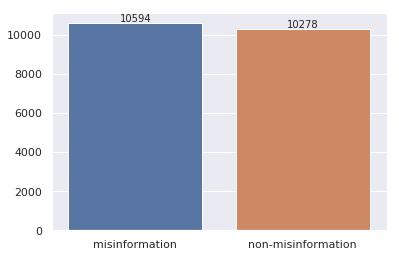

In [66]:
print('total data')
pos_mask = y == 1 
pos = y[pos_mask]
neg_mask = y == 0 
neg = y[neg_mask]
values = [pos.shape[0],neg.shape[0]]
keys = ['misinformation', 'non-misinformation']
g = sns.barplot(x = keys, y = values)
for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., 
                                               p.get_height()), ha = 'center', 
               va = 'center', xytext = (0, 5), textcoords = 'offset points')

data after remove duplicates


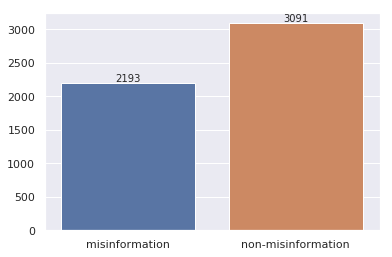

In [67]:
#removing duplicates
    
df = df.drop_duplicates(subset=['text'])
df = df[df['midia']==0]
df = df[['text','misinformation', 'words','characters']]
texts = df['text']
y = df['misinformation']

print('data after remove duplicates')
pos_mask = y == 1 
pos = y[pos_mask]
neg_mask = y == 0 
neg = y[neg_mask]
values = [pos.shape[0],neg.shape[0]]
keys = ['misinformation', 'non-misinformation']
g = sns.barplot(x = keys, y = values)
for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., 
                                               p.get_height()), ha = 'center', 
               va = 'center', xytext = (0, 5), textcoords = 'offset points')

In [68]:
print(len(texts))
print(len(y))

5284
5284


# Handcrafted features
**morphologic**
* use of uppercase: VOCÊS VIRAM ISSO?
* bold or italic texts: * ***texto*** * or _ *texto* _
* linebreaks: '\n'
* use of emojis and punctuation: ☝☝☝😡😡😡😡 ??!!!
* urls

**semantic**
* non-identified author or persons
* vague information
* alarmist
* negative content
* outdated

In [69]:
print('misinformation\n***')
m_list = (list(df[df['misinformation']==1]['text'].sample(n=3, random_state=42)))
for m in m_list:
    print(m)
    print('***')
print()

misinformation
***
Atenção 1: "Firmino Filho e W.Dias, vocês conseguem enganar a milhões de nós, suas vítimas, porém, não conseguem enganar a todos nós. Na verdade, o seu feudo Teresindia, a sua capitania hereditária do Pioi, está uma grande merda". (Os Indignados). O INPE acaba de divulgar uma informação diabólica que só comprova as nossas velhas e racionais previsões; Em 10/15 anos, toda essa cspitaleca, todo essa sesmaria Pioi estará inviabilizada (inabitável) devido os 47 graus de temperatura a sombra e a ausência total de água potável (o aquecimento global). 600 focos de queimadas registradas em apenas um (1) dia só no Sul da capitania (na cspitaleca do Firmino Filho são 100 focos de queimadas). Essa tragédia decorre da entrega de nossas terras, babaçuais, matas ciliares e nativas, do cerrado feita, em troca de votos, pelos entreguistas aos agronegocistas gaúchos e chineses (ao agronegócio: Comvap, Suzano, Terracal, Tomazzine, Bunge e o diabo a quatro). Para não perderem tempo com

In [70]:
#lower/uppercase
df['uppercase count'] = [sum(map(str.isupper, t)) for t in df['text']]
df['lowercase count'] = [sum(map(str.islower, t)) for t in df['text']]
df['lowercase ratio'] = df['lowercase count']/df['characters']
df['uppercase ratio'] = df['uppercase count']/df['characters']

In [12]:
#linebreak
df['line breaks'] = [t.count('\n') for t in df['text']]
df['line breaks radio'] = df['line breaks']/df['words']

In [13]:
#url
def countURLs(text):
    '''
    Count urls from text
    Input: string
    Output: number of urls
    '''
    re_url = '[^\s]*https*://[^\s]*'
    matches = re.findall(re_url,text, flags=re.IGNORECASE)
    return len(matches)

df['number of urls'] = [countURLs(t) for t in df['text']]
df['urls ratio'] = df['number of urls']/df['words']

In [14]:
#emojis
emojis_list = list(emoji.UNICODE_EMOJI.keys())

def emojiCount(string):
    '''
    total of emojis, unique emojis, variability of emojis, emoji/char ratio
    '''
    chars = list(string)
    emojis_found = []
    for char in chars:
        if char in emojis_list:
            emojis_found.append(char)
    emoji_set = set(emojis_found)
    unique_emojis = len(emoji_set)
    total_emojis = len(emojis_found)
    variability = 0
    
    if total_emojis > 0:
        variability = unique_emojis/total_emojis
        
    emoji_ratio = total_emojis/len(string) 
    
    return total_emojis, unique_emojis, variability, emoji_ratio

emoji = [emojiCount(t) for t in df['text']]

In [15]:
df['total emojis'] = [tup[0] for tup in emoji]
df['unique emojis'] = [tup[1] for tup in emoji]
df['variability emojis'] = [tup[2] for tup in emoji]
df['emoji ratio'] = [tup[3] for tup in emoji]

In [16]:
#punctuation
punct_list = list(string.punctuation)
def punctCount(string):
    '''
    total of punctuation, total of exclamation, total of interrogations, exclamation ratio
    '''
    chars = list(string)
    punct_found = []
    for char in chars:
        if char in punct_list:
            punct_found.append(char)            
    punct_set = set(punct_found)
    
    unique_punct = len(punct_set)
    total_punct = len(punct_found)
    variability = 0
    
    if total_punct > 0:
        variability = unique_punct/total_punct 
        
    punct_ratio = total_punct/len(string)    
    exclamations = string.count('!')
    exclamations_ratio = exclamations/len(string)
    
    return total_punct, unique_punct, variability, punct_ratio, exclamations, exclamations_ratio

punct = [punctCount(t) for t in df['text']]    

In [17]:
df['total punctuation signs'] = [tup[0] for tup in punct]
df['unique punctuation signs'] = [tup[1] for tup in punct]
df['variability punctuation signs'] = [tup[2] for tup in punct]
df['punctuation signs ratio'] = [tup[3] for tup in punct]
df['total exclamation signs'] = [tup[4] for tup in punct]
df['exclamation ratio'] = [tup[5] for tup in punct]

In [18]:
df.head(20)

,text,misinformation,words,characters,uppercase count,lowercase count,lowercase ratio,uppercase ratio,line breaks,line breaks radio,...,total emojis,unique emojis,variability emojis,emoji ratio,total punctuation signs,unique punctuation signs,variability punctuation signs,punctuation signs ratio,total exclamation signs,exclamation ratio
1,O Bolsonaro tem que estar preparado pra respon...,0,9,58,2,45,0.775862,0.034483,0,0.000000,...,0,0,0.000000,0.000000,3,1,0.333333,0.051724,0,0.000000
15,"No dia 07 de Outubro, quando for votar, não es...",1,18,99,2,75,0.757576,0.020202,0,0.000000,...,0,0,0.000000,0.000000,3,2,0.666667,0.030303,0,0.000000
26,Devido a aborrecimentos nas varias redes socia...,0,17,114,1,93,0.815789,0.008772,0,0.000000,...,0,0,0.000000,0.000000,4,2,0.500000,0.035088,0,0.000000
43,EU GOSTARIA DE PEDIR A TODOS DO GRUPOS ENTREM ...,0,47,330,168,94,0.284848,0.509091,4,0.085106,...,0,0,0.000000,0.000000,17,6,0.352941,0.051515,0,0.000000
103,Como são as coisas.\nChefe do jacaré aparece n...,1,39,226,5,179,0.792035,0.022124,2,0.051282,...,0,0,0.000000,0.000000,4,2,0.500000,0.017699,0,0.000000
112,A ratoeira funcionou mais a ratazana aguentou ...,0,11,67,1,56,0.835821,0.014925,0,0.000000,...,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0,0.000000
130,"Duas das maiores potências em vendas no Mundo,...",0,26,157,5,124,0.789809,0.031847,0,0.000000,...,0,0,0.000000,0.000000,3,2,0.666667,0.019108,0,0.000000
133,"Relaxando no sofá, barriguinha plusize, 9mm na...",0,30,188,4,140,0.744681,0.021277,0,0.000000,...,0,0,0.000000,0.000000,10,3,0.300000,0.053191,1,0.005319
143,Sistema anti furto. Funciona nos carros GM. Nã...,0,12,70,5,51,0.728571,0.071429,0,0.000000,...,0,0,0.000000,0.000000,3,1,0.333333,0.042857,0,0.000000
161,"*No Ceará, o Comando Vermelho( CV ) PROIBIU pr...",1,35,339,41,217,0.640118,0.120944,6,0.171429,...,0,0,0.000000,0.000000,35,10,0.285714,0.103245,0,0.000000


In [19]:
filepath_features = 'data/2018/fakeWhatsApp.BR_2018-handcrafted_features.csv '
df.to_csv(filepath_features, index = False)

In [155]:
df = pd.read_csv(filepath_features)
X = df[df.columns[1:]]

In [156]:
X['misinformation label'] = ['misinformation' if m == 1 else 'non-misinformation' for m in df['misinformation']]
cols = X.columns
cols = ['misinformation label', 'words', 'characters', 'uppercase count',
       'lowercase count', 'lowercase ratio', 'uppercase ratio', 'line breaks',
       'line breaks radio', 'number of urls', 'urls ratio', 'total emojis',
       'unique emojis', 'variability emojis', 'emoji ratio',
       'total punctuation signs', 'unique punctuation signs',
       'variability punctuation signs', 'punctuation signs ratio',
       'total exclamation signs', 'exclamation ratio', 'misinformation']
X = X[cols]

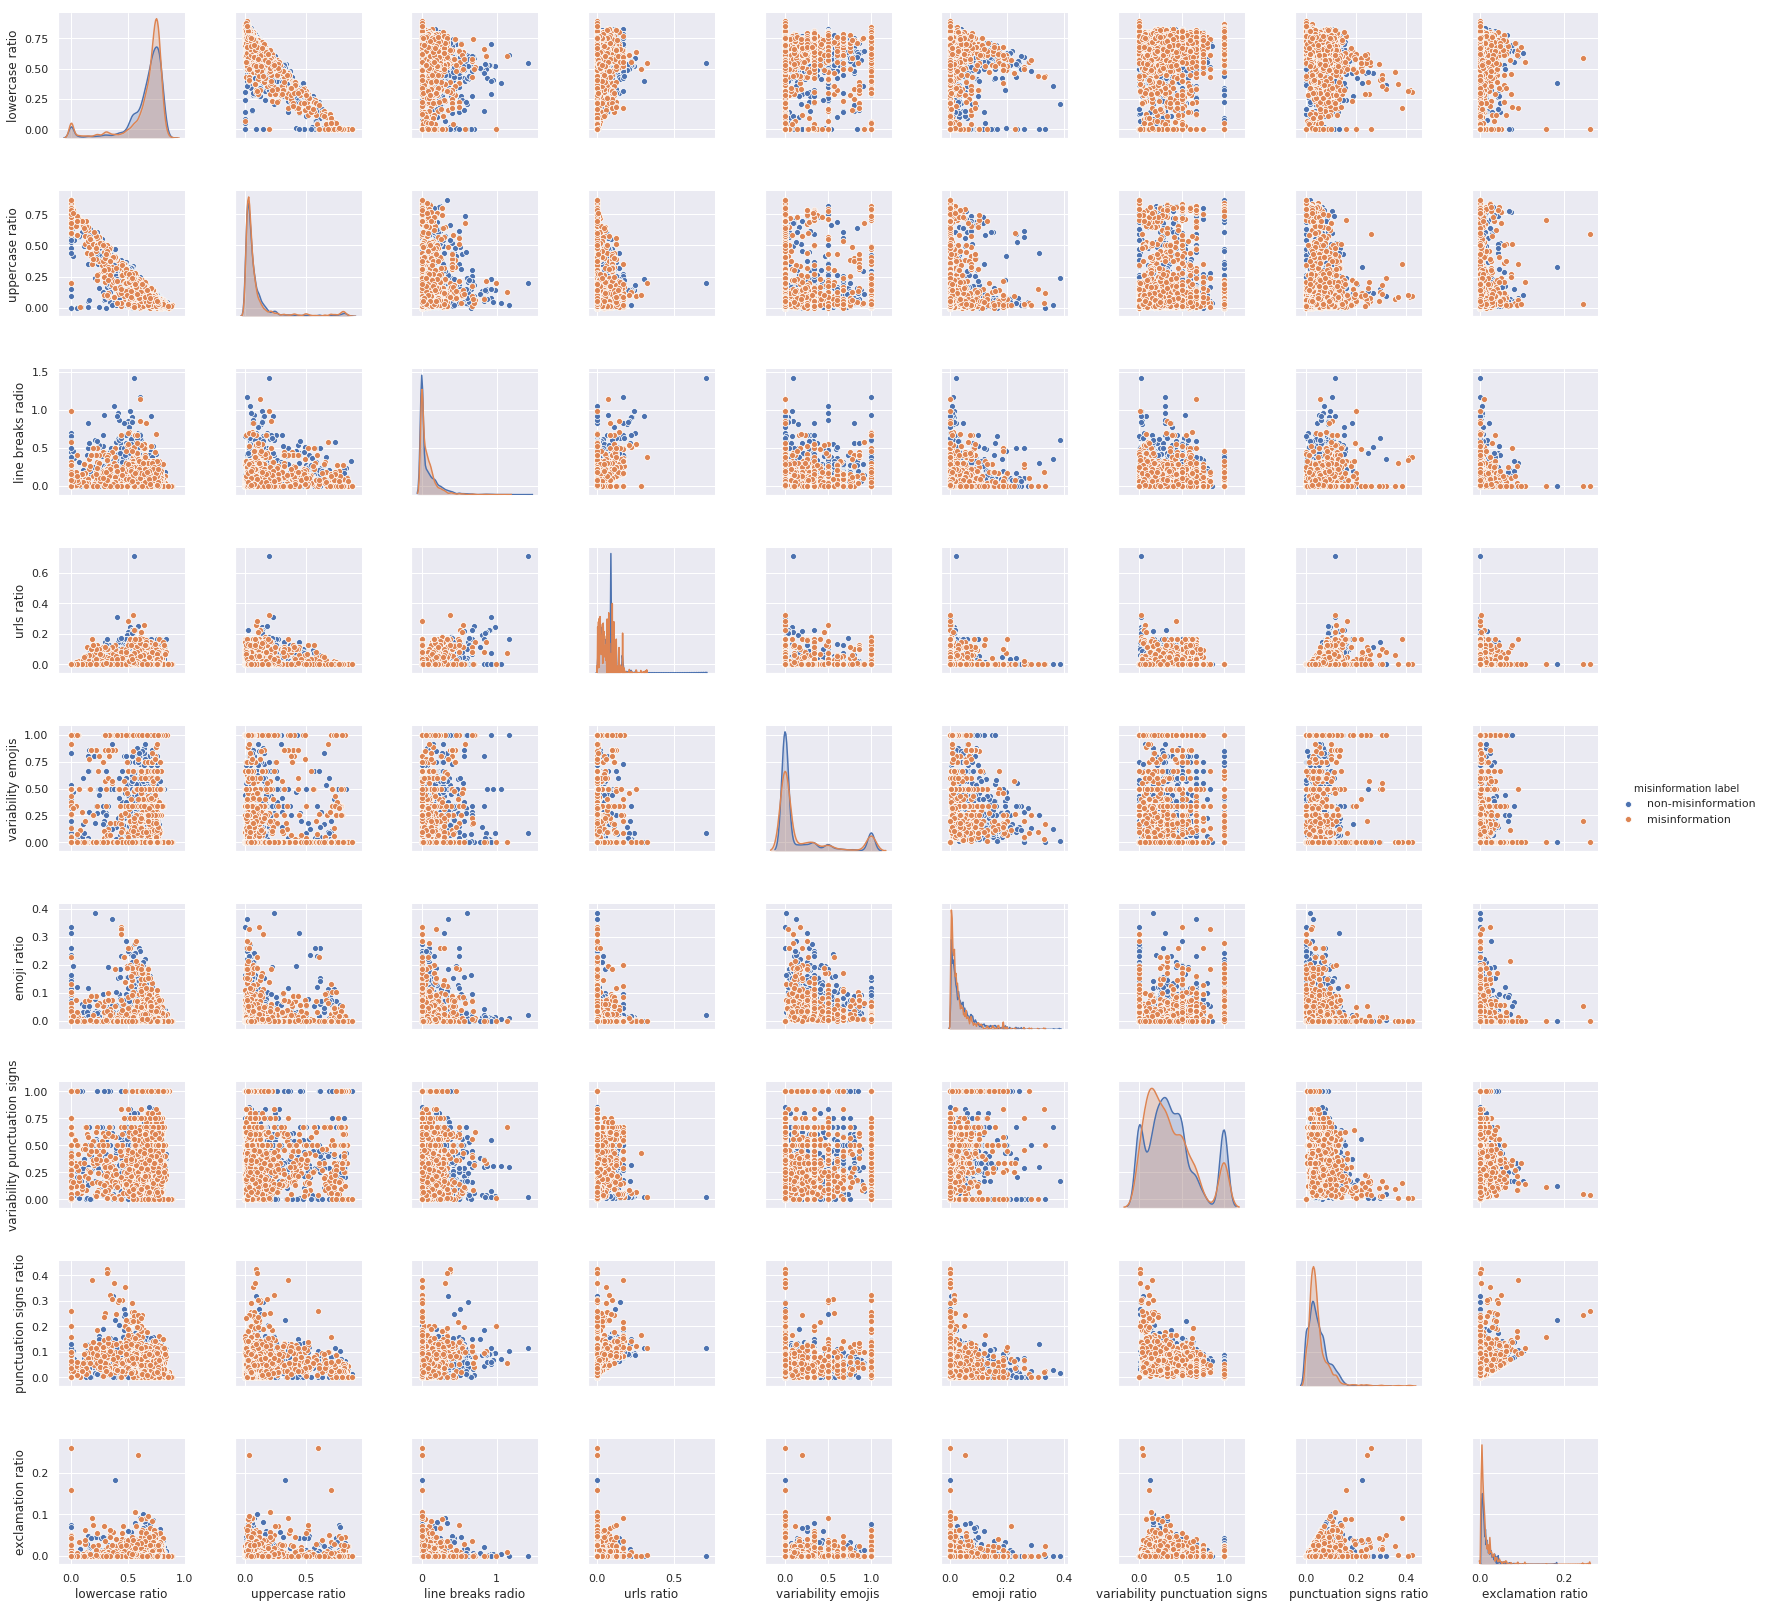

In [157]:
ratio_features = X[['lowercase ratio', 'uppercase ratio',
                    'line breaks radio', 'urls ratio', 'variability emojis', 'emoji ratio',
                    'variability punctuation signs', 'punctuation signs ratio',
                    'exclamation ratio', 'misinformation label']]
sns.pairplot(ratio_features, hue="misinformation label")

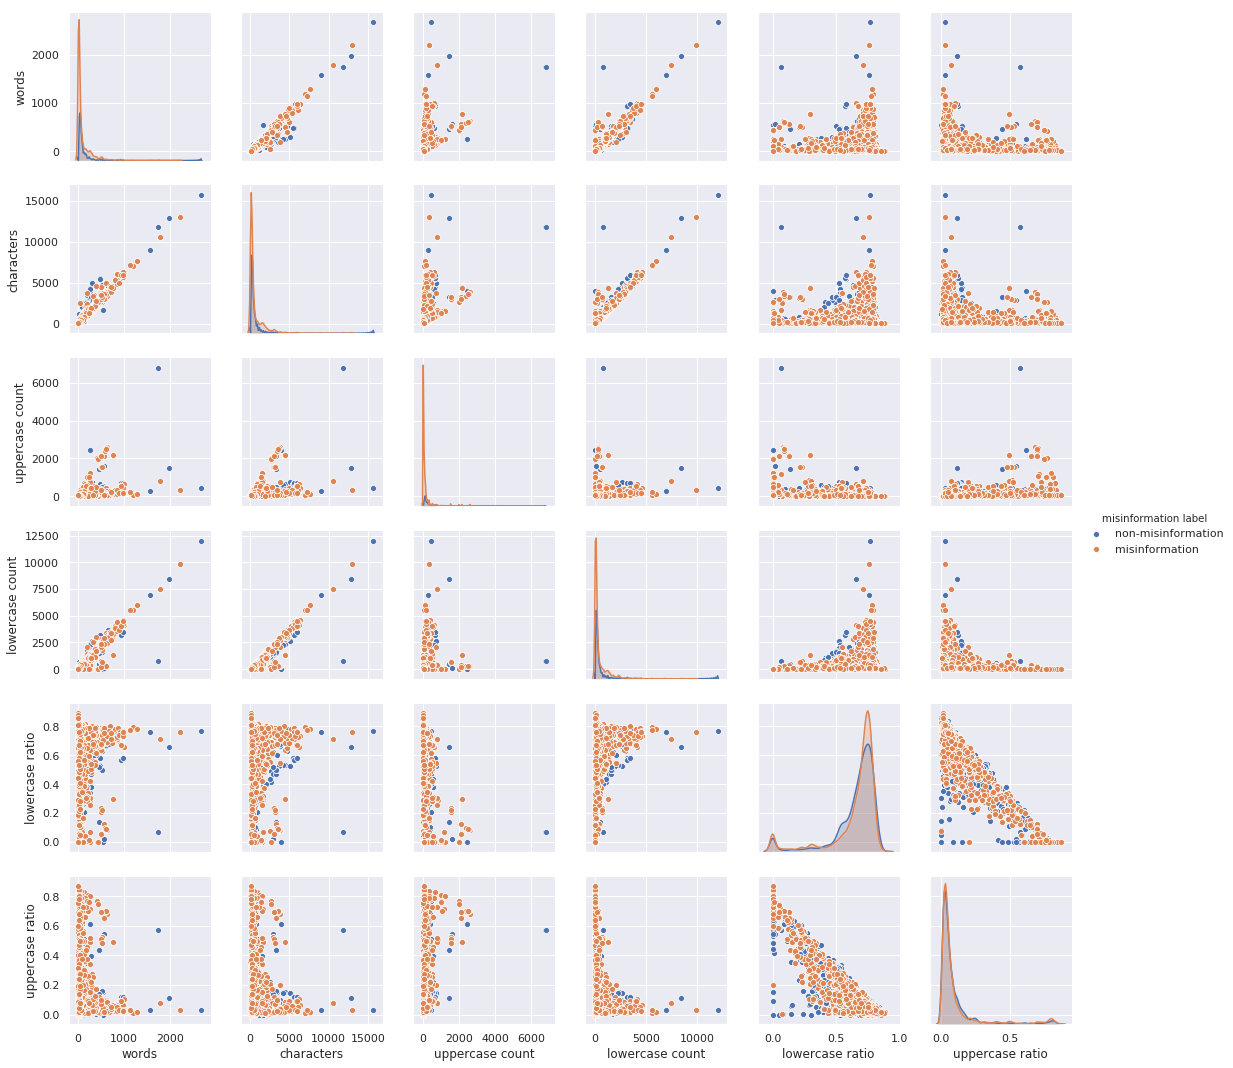

In [141]:
sns.pairplot(X[X.columns[0:7]], hue="misinformation label")

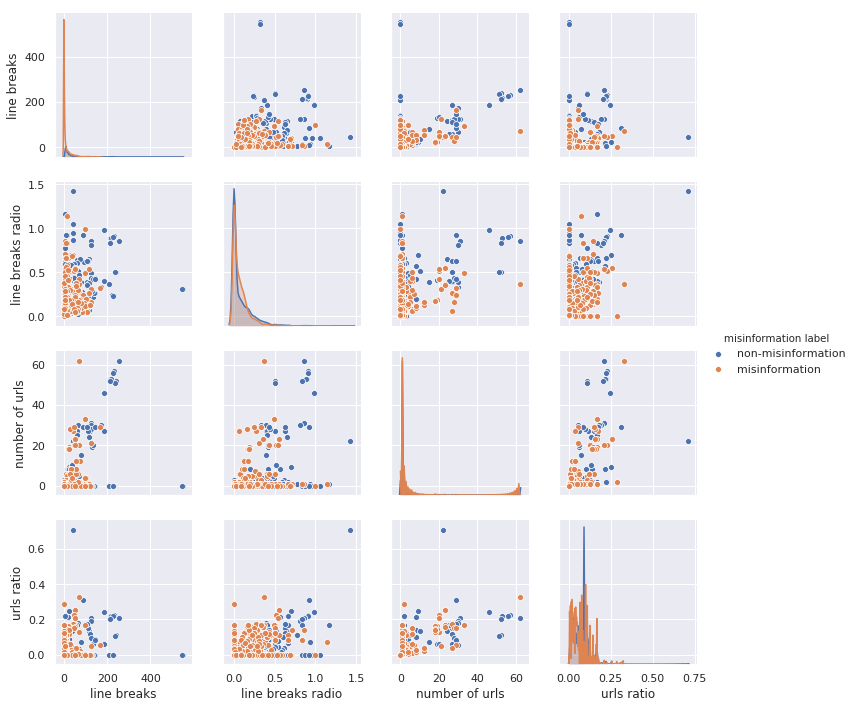

In [144]:
sns.pairplot(X[['line breaks', 'line breaks radio', 'number of urls', 'urls ratio','misinformation label']], hue="misinformation label")

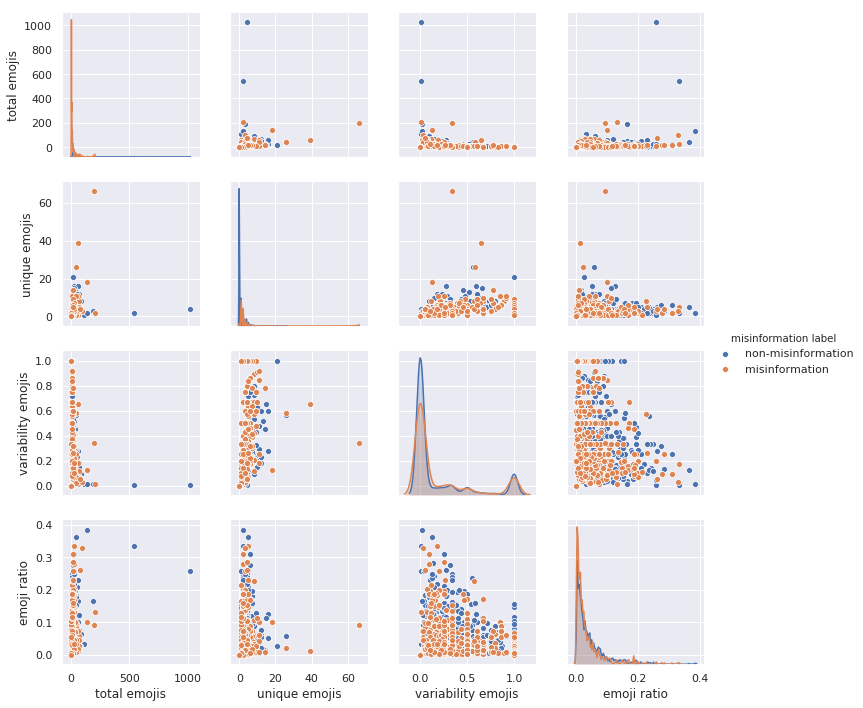

In [145]:
sns.pairplot(X[['total emojis',
       'unique emojis', 'variability emojis', 'emoji ratio','misinformation label']], hue="misinformation label")

In [158]:
X = df[df.columns[2:]]

In [159]:
X = X[['lowercase ratio', 'uppercase ratio',
       'line breaks radio', 'urls ratio', 'variability emojis', 'emoji ratio',
       'variability punctuation signs', 'punctuation signs ratio',
       'exclamation ratio']]

In [160]:
X = X.to_numpy()
X.shape

(5284, 9)

In [161]:
len(y)

5284

## Train-test split

In [162]:
#random state = 42 for reprudictibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                                    stratify = y, random_state=42)

full_texts_train, full_texts_test, y_train, y_test = train_test_split(texts, y, test_size=0.2, 
                                                                    stratify = y, random_state=42)

#normalization
mu = np.mean(X_train, 0)
sigma = np.std(X_train, 0)
X_train = (X_train - mu ) / sigma
X_test = (X_test - mu ) / sigma

## PCA visualization

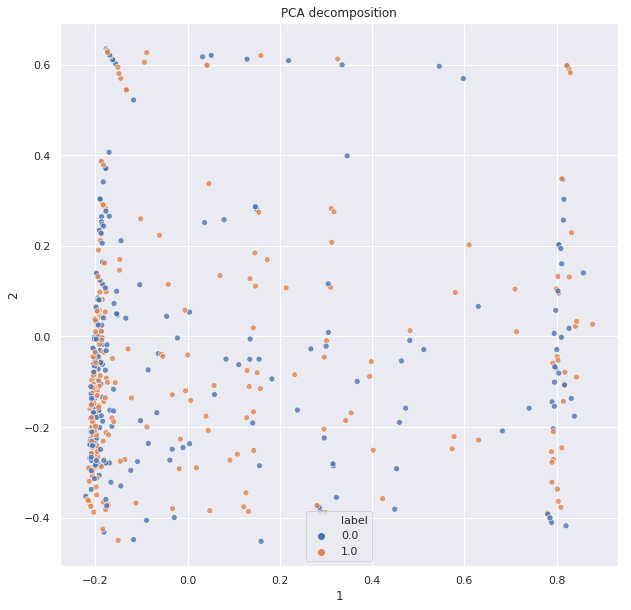

In [163]:
n_components = 2
title = "PCA decomposition"
# Creation of the model
mod = PCA(n_components=n_components)
# Fit and transform the features
principal_components = mod.fit_transform(X)

# Put them into a dataframe
df_features = pd.DataFrame(data=principal_components,
                 columns=['1', '2'])

df_features['label'] = y

# Plot
plt.figure(figsize=(10,10))
sns.scatterplot(x='1',
                y='2',
                hue="label", 
                data=df_features,
                alpha=.8).set_title(title);

## Data balancing

In [164]:
if 'smote' in experiment:
    #oversampling with SMOTE
    sm = SMOTE(random_state = 42)
    X_train, y_train = sm.fit_resample(X_train, y_train)
elif 'undersampling' in experiment:
    rus = RandomUnderSampler(random_state = 42)
    X_train, y_train = rus.fit_resample(X_train, y_train)
elif 'random_oversampling' in experiment:
    ros = RandomOverSampler(random_state=42)
    X_train, y_train = ros.fit_resample(X_train, y_train)
vocab_size = X_train.shape[1]    
X_train.shape

(4946, 9)

## Metrics

In [165]:
scenario = []
model = []
accuracy_score = []
precision_score = []
recall_score = []
f1_score = []
auc_score = []

## Models training and test

Logistic Regression
              precision    recall  f1-score   support

           0       0.66      0.55      0.60       618
           1       0.48      0.59      0.53       439

    accuracy                           0.57      1057
   macro avg       0.57      0.57      0.56      1057
weighted avg       0.58      0.57      0.57      1057

AUC:  0.5873749548473657


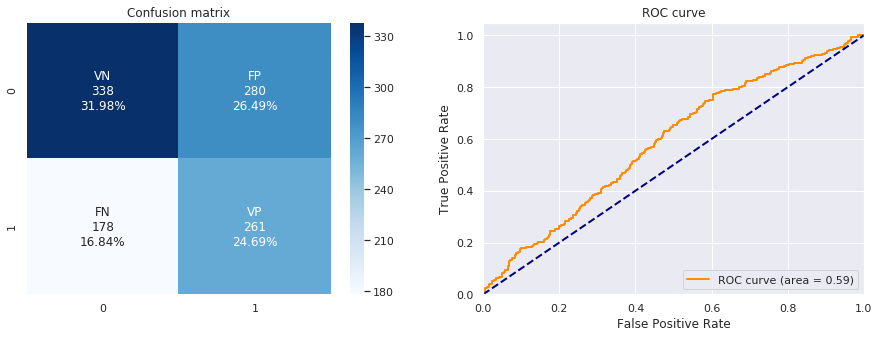

In [166]:
print('Logistic Regression')
logreg = LogisticRegression().fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('logistic regression')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

Bernoulli Naive-Bayes
              precision    recall  f1-score   support

           0       0.64      0.40      0.49       618
           1       0.45      0.68      0.54       439

    accuracy                           0.52      1057
   macro avg       0.54      0.54      0.52      1057
weighted avg       0.56      0.52      0.51      1057

AUC:  0.5796068587773034


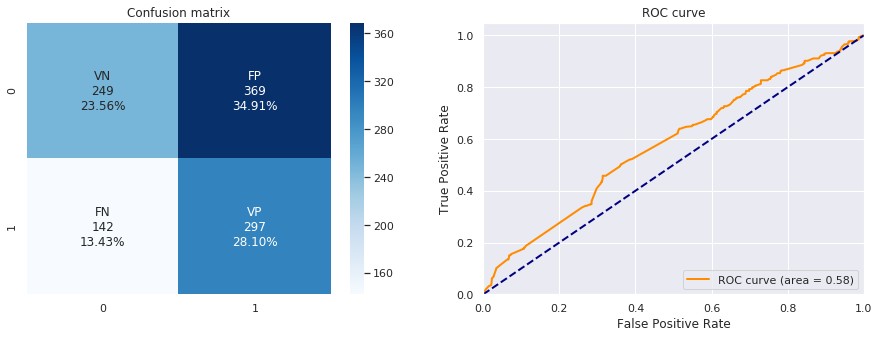

In [167]:
print('Bernoulli Naive-Bayes')
bnb = BernoulliNB().fit(X_train, y_train)
y_pred = bnb.predict(X_test)
y_prob = bnb.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('bernoulli naive-bayes')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

In [168]:
print('Multinomial Naive-Bayes')
mnb = MultinomialNB().fit(X_train, y_train)
y_pred = mnb.predict(X_test)
y_prob = mnb.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('multinomial naive-bayes')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

Multinomial Naive-Bayes


ValueError: Negative values in data passed to MultinomialNB (input X)

Linear Support Vector Machine
              precision    recall  f1-score   support

           0       0.66      0.55      0.60       618
           1       0.48      0.60      0.53       439

    accuracy                           0.57      1057
   macro avg       0.57      0.57      0.56      1057
weighted avg       0.58      0.57      0.57      1057



/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


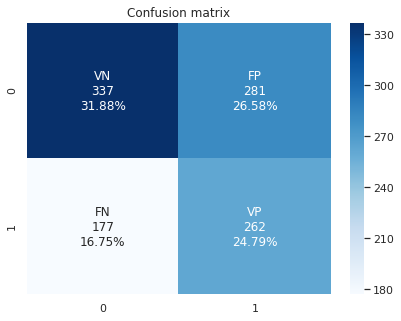

In [169]:
print('Linear Support Vector Machine')
svm = LinearSVC().fit(X_train, y_train)
y_pred = svm.predict(X_test)
#y_prob = svm.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred)

model.append('linear svm')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

KNN
              precision    recall  f1-score   support

           0       0.68      0.61      0.64       618
           1       0.52      0.60      0.56       439

    accuracy                           0.61      1057
   macro avg       0.60      0.61      0.60      1057
weighted avg       0.62      0.61      0.61      1057

AUC:  0.6563018333812504


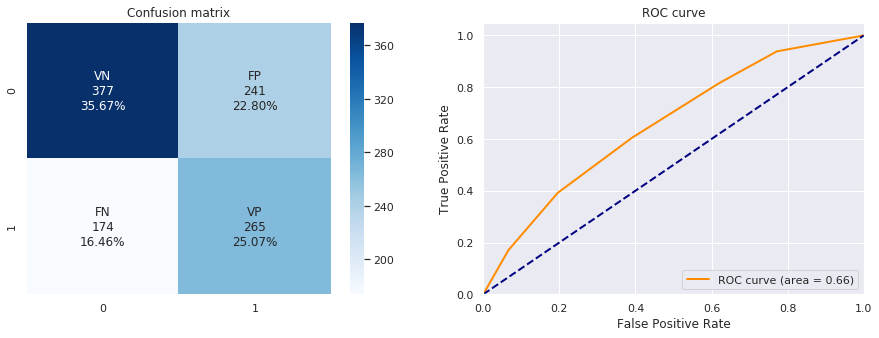

In [170]:
print('KNN')
rf = KNeighborsClassifier().fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('knn')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

Random Forest
              precision    recall  f1-score   support

           0       0.71      0.75      0.73       618
           1       0.61      0.56      0.59       439

    accuracy                           0.67      1057
   macro avg       0.66      0.66      0.66      1057
weighted avg       0.67      0.67      0.67      1057

AUC:  0.7389329971765781


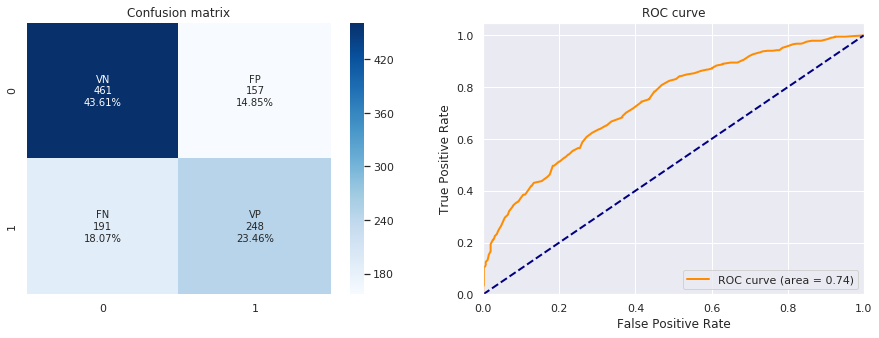

In [125]:
print('Random Forest')
rf = RandomForestClassifier().fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('random forest')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

Gradient Boosting
              precision    recall  f1-score   support

           0       0.73      0.71      0.72       618
           1       0.61      0.63      0.62       439

    accuracy                           0.68      1057
   macro avg       0.67      0.67      0.67      1057
weighted avg       0.68      0.68      0.68      1057

AUC:  0.7429819905492772


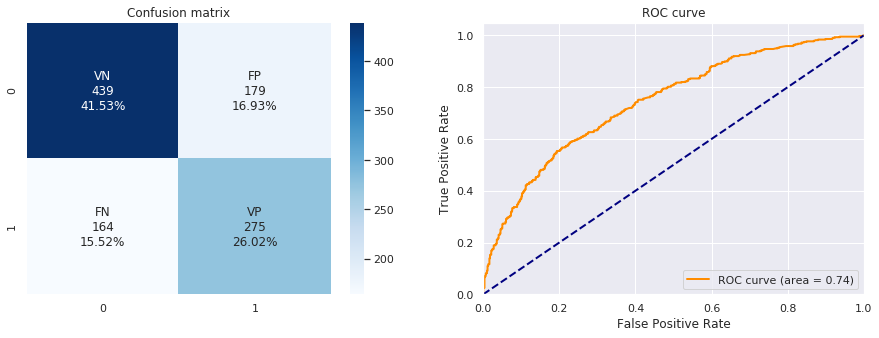

In [171]:
print('Gradient Boosting')
gb = GradientBoostingClassifier().fit(X_train, y_train)
y_pred = gb.predict(X_test)
y_prob = gb.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('gradient boosting')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

Multilayer perceptron
Iteration 1, loss = 0.70165161
Validation score: 0.519192
Iteration 2, loss = 0.67925027
Validation score: 0.581818
Iteration 3, loss = 0.67287766
Validation score: 0.589899
Iteration 4, loss = 0.66774999
Validation score: 0.595960
Iteration 5, loss = 0.66428291
Validation score: 0.597980
Iteration 6, loss = 0.66059457
Validation score: 0.597980
Iteration 7, loss = 0.65688295
Validation score: 0.608081
Iteration 8, loss = 0.65370793
Validation score: 0.612121
Iteration 9, loss = 0.65074044
Validation score: 0.604040
Iteration 10, loss = 0.64803722
Validation score: 0.628283
              precision    recall  f1-score   support

           0       0.72      0.58      0.65       618
           1       0.54      0.68      0.60       439

    accuracy                           0.62      1057
   macro avg       0.63      0.63      0.62      1057
weighted avg       0.64      0.62      0.63      1057

AUC:  0.6870498558801631


/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


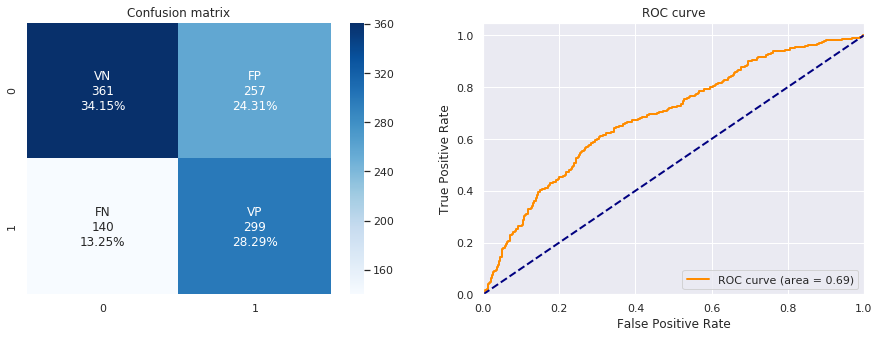

In [172]:
print('Multilayer perceptron')
mlp = MLPClassifier(max_iter = 10, verbose=True, early_stopping= True).fit(X_train, y_train)
y_pred = mlp.predict(X_test)
y_prob = mlp.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

model.append('mlp')
accuracy_score.append(acc)
precision_score.append(precision)
recall_score.append(recall)
f1_score.append(f1)
auc_score.append(roc_auc)

## Results

In [128]:
end_time = time.time()
ellapsed_time = end_time - start_time
print('ellapsed time (min):', ellapsed_time/60)

ellapsed time (min): 52.176686596870425


In [173]:
df_metrics = pd.DataFrame({'model':model,
                                 'accuracy':accuracy_score,
                                 'precision': precision_score,
                                 'recall': recall_score,
                                 'f1 score': f1_score,
                                 'auc score': auc_score})

df_metrics['vocab'] = [vocab_size]*len(df_metrics)
df_metrics

,model,accuracy,precision,recall,f1 score,auc score,vocab
0,logistic regression,0.566698,0.482440,0.594533,0.532653,0.587375,9
1,bernoulli naive-bayes,0.516556,0.445946,0.676538,0.537557,0.579607,9
2,linear svm,0.566698,0.482505,0.596811,0.533605,0.000000,9
3,knn,0.607379,0.523715,0.603645,0.560847,0.656302,9
4,gradient boosting,0.675497,0.605727,0.626424,0.615901,0.742982,9
5,mlp,0.624409,0.537770,0.681093,0.601005,0.687050,9


In [174]:
filepath = 'results/' + base + '/' + subset + '/ml/' + experiment + '.csv'
filepath

'results/2018/viral/ml/ml-hand_features-random_oversampling.csv'

In [175]:
df_metrics.to_csv(filepath, index = False)

# Error examples with mlp

In [112]:
# 1-1 = 0 true positive
# 0-0 = 0 true negative
# 1-0 = 1 false negative
# 0-1 = -1 false positive
y_pred = mlp.predict(X_test)
y_fails = y_test - y_pred
FN = [index for index, value in enumerate(y_fails) if value == 1]
FP = [index for index, value in enumerate(y_fails) if value == -1]

print('Total test data:', len(y_pred))
print('False negative: ',len(FN))
print('False positive: ',len(FP))

Total test data: 1057
False negative:  132
False positive:  288


In [113]:
full_texts_test = list(full_texts_test)

In [114]:
texts_FN = [full_texts_test[fn] for fn in FN]
texts_FP = [full_texts_test[fp] for fp in FP]

### False negative

In [115]:
for fn in texts_FN:
    print('***')
    print(fn)
    print('***')

***
Maduro  acaba de decretar na Venezuela.

Era isto que Lula queria fazer aqui no Brasil..
***
***
Escuta a fala sensata e inteligente do Miguel Falabella.
👇🏻👇🏻👇🏻👇🏻👇🏻👇🏻👇🏻👇🏻👇🏻👇🏻👇🏻
***
***
👆🏻Olha o valentão aí, a Polícia fez um excelente trabalho. Jair Bolsonaro urgente no primeiro turno.
***
***
A morte da velha política no Brasil, comentário de Alexandre Garcia.👇🏻👇🏻👇🏻
***
***
Manifestantes se passando por eleitores de Bolsonaro e insinuando distribuir capim ao eleitores de Lula.
***
***
.


Inclusive eu tenho uma cunhada que era contra o BOLSONARO 
Depois do ocorrido com o mito ela virou o voto dela é das três filhas 
Agora elas são BOLSONARO 
Tudo porque ela não gostou da covardia que fizeram com BOLSONARO 
É isso aí vamo que vamo 
👍🏾👍🏾👍🏾👍🏾👍🏾
Que Deus olhe por todos nós
***
***
A melhor explicação que já ouvi sobre Lula. De uma nordestina, simples e lógica 👆👆👆
***
***
Muitos estão esquecendo o que o PT tentou fazer quando estava no governo.  Seria bom que vissem esse vídeo para refr

### False positives

In [116]:
for fp in texts_FP:
    print()
    print('***')
    print(fp)
    print('***')
    print()


***
*Em Minas, o General de Brigada Marco Felício (1760), último comandante de Bolsonaro, declara apoio a Romeu Zema(30) e ajuda a levar o candidato Outsider de Minas para o segundo turno.*

*Um dos mais fortes candidatos de Bolsonaro à câmara federal está levando a Campanha de Bolsonaro em Minas assim como Bolsonaro17 sem utilizar recursos públicos.*

*PSDB, PT e PMDB EM MINAS ESTÃO COM OS DIAS CONTADOS.*

http://marcofelicio.com.br/voto-bolsozema-ganha-forca-e-pode-levar-zema-ao-segundo-turno-em-minas/
***


***
Cansei de falar de política, só dá desavença nos grupos de WhatsApp.
Vamos falar um pouco de culinária. 
Nesse frio, uma sopa cai muito bem...
***


***
😱 Marina Silva também sofre atentado.
Acabam de jogar nela um estojo de maquiagem Jequiti.
Ela "passa bem", mas continua feia 👹  pra caramba.
***


***
PESSOAL ASSISTA O ÚLTIMO VÍDEO DE JAIR BOLSONARO QUE FOI FEITO ONTEM , AO VIVO . ELE MESMO ESTÁ ORIENTANDO. E PARA IR UM POUCO ANTES DAS 17HS NO LOCAL ONDE VOCE VOTOU ESPERA 

# MLP Hyperparameter tunning with random search

In [41]:
#validation set
X_train_val, X_val, y_train_val, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42, stratify = y_train)

In [42]:
def randomLayers():
    '''
    Create a tuple random of hidden_layer_sizes. 
    '''
    n_layers = np.random.randint(1,4)
    layers_list = []
    for i in range(n_layers):            
        hidden_neurons = np.random.randint(10,300)
        layers_list.append(hidden_neurons)
    layers_tuple = tuple(layers_list)
    return layers_tuple

       
print(randomLayers())
    

(151,)


## Hyperparameters

MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', *, solver='adam', alpha=0.0001, batch_size='auto', learning_rate='constant', learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08, n_iter_no_change=10, max_fun=15000)[source].

In [43]:
hyperparams = []
best_hyperpams = []
results = []
n_iter = 20
best_score = 0
np.random.seed(42)

activation_list = ['logistic', 'tanh', 'relu']
solver_list = ['sgd', 'adam', 'lbfgs']
learning_rate_list = ['constant'] #,'adaptive']

for i in range(n_iter):
    print(str(i+1) + '/' + str(n_iter))
    
    # hidden layers
    hidden_layer_sizes = randomLayers()
    
    #activation
    s = np.random.randint(len(activation_list))
    activation = activation_list[s]
    
    #solver
    s = np.random.randint(len(solver_list))
    solver = solver_list[s]
    
    #alpha
    s = np.random.uniform(-4,-0.5)
    alpha = 10**s
    
    #learning rate
    s = np.random.randint(len(learning_rate_list))
    learning_rate = learning_rate_list[s]
    
    # max of iterations during training
    max_iter = np.random.randint(5,20) 
   
    hyperparams.append([hidden_layer_sizes, activation, solver, alpha, learning_rate, max_iter])
    
    print('training: ')
    print(hyperparams[i])
    
    mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, 
                        activation=activation, 
                        solver=solver, 
                        alpha=alpha, 
                        learning_rate=learning_rate, 
                        max_iter = max_iter,
                        verbose=True, early_stopping= True, 
                        n_iter_no_change = 5).fit(X_train_val, y_train_val)
    
    y_pred = mlp.predict(X_val)
    y_prob = mlp.predict_proba(X_val)[:,1]    
    score = metrics.f1_score(y_val, y_pred, pos_label = 1, average = 'binary')
    results.append(score)
    
    if score > best_score:
        best_score = score
        best_hyperpams = [hidden_layer_sizes, activation, solver, alpha, learning_rate, max_iter]  
        
        
val_data = list(zip(results,hyperparams))    
val_data = sorted(val_data, key=lambda tup: tup[0],reverse = True)
val_data 

1/20
training: 
[(229, 142, 64), 'relu', 'sgd', 0.002440060709081752, 'constant', 14]
Iteration 1, loss = 0.69783335
Validation score: 0.500000
Iteration 2, loss = 0.69783835
Validation score: 0.500000
Iteration 3, loss = 0.69781539
Validation score: 0.500000
Iteration 4, loss = 0.69769626
Validation score: 0.500000
Iteration 5, loss = 0.69755740
Validation score: 0.515695
Iteration 6, loss = 0.69748253
Validation score: 0.531390
Iteration 7, loss = 0.69743379
Validation score: 0.517937
Iteration 8, loss = 0.69742262
Validation score: 0.500000
Iteration 9, loss = 0.69732147
Validation score: 0.529148
Iteration 10, loss = 0.69730105
Validation score: 0.526906
Iteration 11, loss = 0.69733309
Validation score: 0.538117
Iteration 12, loss = 0.69717971
Validation score: 0.524664
Iteration 13, loss = 0.69712519
Validation score: 0.538117
Iteration 14, loss = 0.69708437
Validation score: 0.515695
2/20
training: 
[(232, 111), 'tanh', 'lbfgs', 4.666754684250427e-05, 'constant', 10]


/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (14) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


3/20
training: 
[(88, 166, 257), 'logistic', 'sgd', 1.1666608051749357e-05, 'constant', 10]
Iteration 1, loss = 0.69385984
Validation score: 0.500000
Iteration 2, loss = 0.69327870
Validation score: 0.500000
Iteration 3, loss = 0.69441591
Validation score: 0.500000
Iteration 4, loss = 0.69473674
Validation score: 0.500000
Iteration 5, loss = 0.69415684
Validation score: 0.500000
Iteration 6, loss = 0.69412772
Validation score: 0.500000
Iteration 7, loss = 0.69348794
Validation score: 0.500000
Validation score did not improve more than tol=0.000100 for 5 consecutive epochs. Stopping.
4/20
training: 
[(247, 187, 125), 'tanh', 'adam', 0.0005389266009253295, 'constant', 13]
Iteration 1, loss = 0.58517416
Validation score: 0.802691
Iteration 2, loss = 0.19887774
Validation score: 0.816143
Iteration 3, loss = 0.08583198
Validation score: 0.827354
Iteration 4, loss = 0.04611940
Validation score: 0.811659
Iteration 5, loss = 0.04583015
Validation score: 0.807175
Iteration 6, loss = 0.04059275


/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.76292641
Validation score: 0.500000
Iteration 2, loss = 0.76179950
Validation score: 0.500000
Iteration 3, loss = 0.76125630
Validation score: 0.500000
Iteration 4, loss = 0.76058083
Validation score: 0.500000
Iteration 5, loss = 0.75992081
Validation score: 0.500000
8/20
training: 
[(93,), 'relu', 'lbfgs', 0.00013412157536967108, 'constant', 14]


/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


9/20
training: 
[(84, 267, 106), 'tanh', 'lbfgs', 0.009388917836117824, 'constant', 7]


/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


10/20
training: 
[(253,), 'logistic', 'adam', 0.0020738241773250597, 'constant', 7]
Iteration 1, loss = 0.68795957
Validation score: 0.612108
Iteration 2, loss = 0.66551277
Validation score: 0.643498
Iteration 3, loss = 0.65609891
Validation score: 0.645740
Iteration 4, loss = 0.63367287
Validation score: 0.766816
Iteration 5, loss = 0.61991965
Validation score: 0.771300
Iteration 6, loss = 0.60512243
Validation score: 0.704036
Iteration 7, loss = 0.59354636
Validation score: 0.681614
11/20
training: 
[(101,), 'tanh', 'lbfgs', 1.7109272788387533e-05, 'constant', 8]


/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (7) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


12/20
training: 
[(244, 136, 237), 'tanh', 'lbfgs', 0.010216531712176236, 'constant', 11]


/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


13/20
training: 
[(241, 288, 198), 'relu', 'adam', 3.072435051178286e-05, 'constant', 16]
Iteration 1, loss = 0.65939302
Validation score: 0.773543
Iteration 2, loss = 0.30980674
Validation score: 0.804933
Iteration 3, loss = 0.09974995
Validation score: 0.795964
Iteration 4, loss = 0.04420315
Validation score: 0.804933
Iteration 5, loss = 0.02414772
Validation score: 0.789238
Iteration 6, loss = 0.01816100
Validation score: 0.786996
Iteration 7, loss = 0.01751733
Validation score: 0.780269
Iteration 8, loss = 0.01247451
Validation score: 0.795964
Validation score did not improve more than tol=0.000100 for 5 consecutive epochs. Stopping.
14/20
training: 
[(221, 240, 161), 'relu', 'adam', 6.07027532893689e-05, 'constant', 5]
Iteration 1, loss = 0.66435644
Validation score: 0.782511
Iteration 2, loss = 0.35023661
Validation score: 0.818386
Iteration 3, loss = 0.11480872
Validation score: 0.816143
Iteration 4, loss = 0.04673279
Validation score: 0.811659
Iteration 5, loss = 0.02859981
Val

/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


16/20
training: 
[(223, 243, 120), 'relu', 'sgd', 4.899139688863978e-05, 'constant', 14]
Iteration 1, loss = 0.69425440
Validation score: 0.500000
Iteration 2, loss = 0.69393107
Validation score: 0.500000
Iteration 3, loss = 0.69372292
Validation score: 0.500000
Iteration 4, loss = 0.69341734
Validation score: 0.506726
Iteration 5, loss = 0.69339995
Validation score: 0.491031
Iteration 6, loss = 0.69334481
Validation score: 0.504484
Iteration 7, loss = 0.69330899
Validation score: 0.504484
Iteration 8, loss = 0.69324698
Validation score: 0.495516
Iteration 9, loss = 0.69324792
Validation score: 0.500000
Iteration 10, loss = 0.69322301
Validation score: 0.500000
Validation score did not improve more than tol=0.000100 for 5 consecutive epochs. Stopping.
17/20
training: 
[(276, 247, 298), 'logistic', 'sgd', 0.044356922319551566, 'constant', 16]
Iteration 1, loss = 0.73658217
Validation score: 0.500000
Iteration 2, loss = 0.73636798
Validation score: 0.500000
Iteration 3, loss = 0.73553757

/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (6) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Iteration 1, loss = 0.70077638
Validation score: 0.500000
Iteration 2, loss = 0.69375773
Validation score: 0.500000
Iteration 3, loss = 0.69357299
Validation score: 0.500000
Iteration 4, loss = 0.69339696
Validation score: 0.500000
Iteration 5, loss = 0.69470968
Validation score: 0.500000
Iteration 6, loss = 0.69526733
Validation score: 0.500000
Iteration 7, loss = 0.69381478
Validation score: 0.500000
Validation score did not improve more than tol=0.000100 for 5 consecutive epochs. Stopping.
20/20
training: 
[(167, 86), 'relu', 'sgd', 0.013313349230514797, 'constant', 9]
Iteration 1, loss = 0.71271625
Validation score: 0.500000
Iteration 2, loss = 0.71184484
Validation score: 0.500000
Iteration 3, loss = 0.71098141
Validation score: 0.500000
Iteration 4, loss = 0.71051049
Validation score: 0.500000
Iteration 5, loss = 0.70998660
Validation score: 0.500000
Iteration 6, loss = 0.70967707
Validation score: 0.500000
Iteration 7, loss = 0.70936072
Validation score: 0.500000
Validation scor

[(0.8266129032258065,
  [(221, 240, 161), 'relu', 'adam', 6.07027532893689e-05, 'constant', 5]),
 (0.8265107212475633,
  [(253,), 'logistic', 'adam', 0.0020738241773250597, 'constant', 7]),
 (0.8233082706766918,
  [(247, 187, 125), 'tanh', 'adam', 0.0005389266009253295, 'constant', 13]),
 (0.8226120857699804,
  [(241, 288, 198), 'relu', 'adam', 3.072435051178286e-05, 'constant', 16]),
 (0.7887323943661971,
  [(93,), 'relu', 'lbfgs', 0.00013412157536967108, 'constant', 14]),
 (0.7870182555780932,
  [(244, 136, 237), 'tanh', 'lbfgs', 0.010216531712176236, 'constant', 11]),
 (0.7484909456740442,
  [(101,), 'tanh', 'lbfgs', 1.7109272788387533e-05, 'constant', 8]),
 (0.7352941176470588,
  [(232, 111), 'tanh', 'lbfgs', 4.666754684250427e-05, 'constant', 10]),
 (0.7230443974630021,
  [(181, 251), 'tanh', 'lbfgs', 0.017467213744690267, 'constant', 7]),
 (0.6987270155586986,
  [(278, 137), 'logistic', 'adam', 1.5423946513482075e-05, 'constant', 6]),
 (0.6900420757363253,
  [(84, 267, 106), 'tan

In [44]:
#best_hyperpams = [hidden_layer_sizes, activation, solver, alpha, learning_rate, max_iter]
hidden_layer_sizes = best_hyperpams[0]
activation = best_hyperpams[1]
solver = best_hyperpams[2]
alpha = best_hyperpams[3]
learning_rate = best_hyperpams[4]
max_iter = best_hyperpams[5]
best_hyperpams

[(221, 240, 161), 'relu', 'adam', 6.07027532893689e-05, 'constant', 5]

In [45]:
mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, 
                    activation=activation, 
                    solver=solver, 
                    alpha=alpha, 
                    learning_rate=learning_rate, 
                    max_iter = max_iter,
                    verbose=True, early_stopping= True, 
                    n_iter_no_change = 5).fit(X_train, y_train)

Iteration 1, loss = 0.64516303
Validation score: 0.783838
Iteration 2, loss = 0.28642960
Validation score: 0.818182
Iteration 3, loss = 0.09616290
Validation score: 0.814141
Iteration 4, loss = 0.04225275
Validation score: 0.810101
Iteration 5, loss = 0.02474035
Validation score: 0.808081


/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


              precision    recall  f1-score   support

           0       0.82      0.81      0.81       618
           1       0.74      0.74      0.74       439

    accuracy                           0.78      1057
   macro avg       0.78      0.78      0.78      1057
weighted avg       0.78      0.78      0.78      1057

AUC:  0.8583497357188667


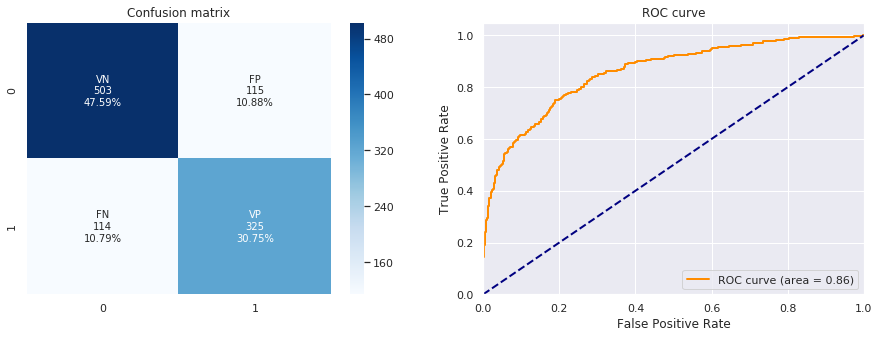

In [46]:
y_pred = mlp.predict(X_test)
y_prob = mlp.predict_proba(X_test)[:,1]
acc, precision, recall, f1, roc_auc = getTestMetrics(y_test, y_pred, y_prob)

In [47]:
print([acc, precision, recall, f1, roc_auc])

[0.783349101229896, 0.7386363636363636, 0.7403189066059226, 0.7394766780432309, 0.8583497357188667]
